In [1]:
#!pip install opencv-python

In [2]:
#!pip install matplotlib

In [3]:
from pymemcache.client.base import PooledClient
from pymemcache import serde
client = PooledClient(('localhost', 11211),serde=serde.pickle_serde, max_pool_size=4)

In [4]:
import os
import shutil
from sqlalchemy import create_engine, event, Table
from sqlalchemy.orm import sessionmaker

import shapely.wkb
import numpy as np
import cv2

from sqlalchemy import inspect


from quickannotator.db import db, Project, Image, AnnotationClass, Notification, Tile, Setting, Annotation, SearchCache, build_annotation_table_name

In [5]:
db_path = "sqlite:////opt/QuickAnnotator/quickannotator/instance/quickannotator.db"
engine = create_engine(db_path)#,echo=True)

# Initialize Spatialite extension
@event.listens_for(engine, "connect")
def connect(dbapi_connection, connection_record):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')
    dbapi_connection.execute('SELECT InitSpatialMetaData(1);')



In [6]:
models = [Image, AnnotationClass, Tile]
db.metadata.create_all(bind=engine, tables=[item.__table__ for item in models])

InitSpatiaMetaData() error:"table spatial_ref_sys already exists"


In [7]:
Session = sessionmaker(bind=engine)
session = Session()

In [8]:
# Get all annotation classes
annotation_classes = session.query(AnnotationClass).all()
print(annotation_classes)

[<AnnotationClass 1>, <AnnotationClass 2>, <AnnotationClass 3>]


In [9]:
class_id = 2

# Query all tiles for the current class
tiles = session.query(Tile).filter_by(annotation_class_id=class_id).all() ## filter by having a gt=True attribute
print(tiles)

[<Tile 1>, <Tile 2>, <Tile 3>, <Tile 4>, <Tile 5>, <Tile 6>, <Tile 7>, <Tile 8>, <Tile 9>, <Tile 10>, <Tile 11>, <Tile 12>, <Tile 13>, <Tile 14>, <Tile 15>, <Tile 16>, <Tile 17>, <Tile 18>, <Tile 19>, <Tile 20>, <Tile 21>, <Tile 22>, <Tile 23>, <Tile 24>, <Tile 25>, <Tile 26>, <Tile 27>, <Tile 28>, <Tile 29>, <Tile 30>, <Tile 31>, <Tile 32>, <Tile 33>, <Tile 34>, <Tile 35>, <Tile 36>, <Tile 37>, <Tile 38>, <Tile 39>, <Tile 40>, <Tile 41>, <Tile 42>, <Tile 43>, <Tile 44>, <Tile 45>, <Tile 46>, <Tile 47>, <Tile 48>, <Tile 49>, <Tile 50>, <Tile 51>, <Tile 52>, <Tile 53>, <Tile 54>, <Tile 55>, <Tile 56>, <Tile 57>, <Tile 58>, <Tile 59>, <Tile 60>, <Tile 61>, <Tile 62>, <Tile 63>, <Tile 64>, <Tile 65>, <Tile 66>, <Tile 67>, <Tile 68>, <Tile 69>, <Tile 70>, <Tile 71>, <Tile 72>, <Tile 73>, <Tile 74>, <Tile 75>, <Tile 76>, <Tile 77>, <Tile 78>, <Tile 79>, <Tile 80>, <Tile 81>, <Tile 82>, <Tile 83>, <Tile 84>, <Tile 85>, <Tile 86>, <Tile 87>, <Tile 88>, <Tile 89>, <Tile 90>, <Tile 91>, <Tile 9

In [10]:
tpoly = shapely.wkb.loads(tiles[0].geom.data)

# Get the bounds of the polygon
minx, miny, maxx, maxy = tpoly.bounds

# Compute the width and height
tile_width = int(maxx - minx)
tile_height = int(maxy - miny)

In [11]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [12]:
#!pip install scipy

In [13]:
import openslide
from torch.utils.data import Dataset, DataLoader, IterableDataset
import numpy as np
from PIL import Image as PILImage
import scipy.ndimage

import io


import albumentations as A
from albumentations.pytorch import ToTensorV2



/opt/QuickAnnotator/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/QuickAnnotator/venv/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [14]:
# Function to convert NumPy array (image) to JPEG bytes
def compress_to_jpeg(matrix):
    # Convert NumPy matrix to a PIL Image
    image = PILImage.fromarray(matrix.astype(np.uint8))
    # Save the image to a BytesIO object as JPEG
    with io.BytesIO() as output:
        image.save(output, format="JPEG")
        jpeg_bytes = output.getvalue()  # Get the byte data
    return jpeg_bytes

# Function to decompress JPEG bytes back to a NumPy array
def decompress_from_jpeg(jpeg_bytes):
    # Open the byte data as an image using PIL
    with io.BytesIO(jpeg_bytes) as input:
        image = PILImage.open(input)
        # Convert image back to NumPy array
        matrix = np.array(image)
    return matrix

In [15]:

from unittest.mock import patch
import torchvision.transforms as transforms

class TileDataset(IterableDataset):
    def __init__(self, tiles, transforms=None,edge_weight=0):
        self.tiles = tiles
        # self.cache = {} #to be convered to memcached #OBSOLETE
        self.transforms = transforms
        self.edge_weight = 0

    def __iter__(self):
        
        inspector = inspect(engine)
        
        for tile in self.tiles:
            image_id = tile.image_id
            tile_id = tile.id
            cache_key = f"{image_id}_{tile_id}"

            cache_val = client.get(cache_key) ## COnsider here storing/retreiving images and masks seperately -- one can query multiple keys at the same time, so there isn't additional overhead but may make things more modular for future usage
            if cache_val:
                print("cache hit")
                io_image, mask_image,weight =  [decompress_from_jpeg(i) for i in cache_val]
            else:
            
                image_id = tile.image_id
                gtpred = 'gt'  # or 'pred' based on your requirement
                table_name = build_annotation_table_name(image_id, class_id, gtpred == 'gt')
                
                if not inspector.has_table(table_name):
                    continue
                
                table = Table(table_name, db.metadata, autoload_with=engine)

                
                annotations = session.query(table).filter(
                    table.c.polygon.ST_Within(tile.geom)
                ).all()

                
                if len(annotations) == 0:
                    continue
                
                tpoly = shapely.wkb.loads(tile.geom.data)

                # Get the bounds of the polygon
                minx, miny, maxx, maxy = tpoly.bounds

                # Compute the width and height
                width = int(maxx - minx)
                height = int(maxy - miny)

                #--- image work
                image = session.query(Image).filter_by(id=image_id).first()
                if not image:
                    continue

                image_path = image.path
                slide = openslide.OpenSlide("../" + image_path)

                # Extract the region defined by the tile
                region = slide.read_region((int(minx), int(miny)), 0, (width, height))
                io_image = np.array(region.convert("RGB"))

                mask_image = np.zeros((height, width), dtype=np.uint8)

                for annotation in annotations:
                    annotation_polygon = shapely.wkb.loads(annotation.polygon.data)
                    translated_polygon = shapely.affinity.translate(annotation_polygon, xoff=-minx, yoff=-miny)
                    cv2.fillPoly(mask_image, [np.array(translated_polygon.exterior.coords, dtype=np.int32)], 1)



                if (self.edge_weight):
                    weight = scipy.ndimage.morphology.binary_dilation(mask_image, iterations=2) & ~mask_image
                else:
                    weight = np.ones(mask_image.shape, dtype=mask_image.dtype)

                client.set(cache_key, [compress_to_jpeg(i) for i in (io_image,mask_image,weight)]) #save non-augmented version
                
            img_new = io_image
            mask_new = mask_image
            weight_new = weight

            if self.transforms:
                augmented = self.transforms(image=io_image, masks=[mask_image, weight])
                img_new = augmented['image']
                mask_new, weight_new = augmented['masks']

            

            

            yield img_new, mask_new.unsqueeze(0), weight_new

# these are transformations from the previous quickannotator version, which may be overkill. i think we'll probably want to either ask Fan
# what he used for his work and/or take a survey of folks in the lab to see what they commonly use. maybe there are some good best practices here.
transforms = A.Compose([
    A.RandomScale(scale_limit=0.1, p=.9),
    A.PadIfNeeded(min_height=tile_height, min_width=tile_width),
    A.VerticalFlip(p=.5),
    A.HorizontalFlip(p=.5),
    A.Blur(p=.5),
    # Downscale(p=.25, scale_min=0.64, scale_max=0.99),
    A.GaussNoise(p=.5, var_limit=(10.0, 50.0)),
    A.GridDistortion(p=.5, num_steps=5, distort_limit=(-0.3, 0.3),
                    border_mode=cv2.BORDER_REFLECT),
    A.ISONoise(p=.5, intensity=(0.1, 0.5), color_shift=(0.01, 0.05)),
    A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
    A.RandomGamma(p=.5, gamma_limit=(80, 120), eps=1e-07),
    A.MultiplicativeNoise(p=.5, multiplier=(0.9, 1.1), per_channel=True, elementwise=True),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=10, val_shift_limit=10, p=.9),
    A.Rotate(p=1, border_mode=cv2.BORDER_REFLECT),
    A.RandomCrop(tile_height, tile_width),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalization
    ToTensorV2()
])


edge_weight=2 #this should be pulled into a project setting
dataset = TileDataset(tiles, transforms=transforms,edge_weight=edge_weight)


/tmp/ipykernel_41824/2125593996.py:109: UserWarning: Argument 'eps' is not valid and will be ignored.
  A.RandomGamma(p=.5, gamma_limit=(80, 120), eps=1e-07),


In [16]:

#this actually crashed on my laptop when batch_size was  larger (i think >=4) due to memory issues - hard to know how much
# of that is due to WSL and how much due to the network/image size. i think we'll want to play with this parameter later on to get
#a better sense of the limitations and appropriate values. e.g., we may need to set "tile size" equal to 1024 x 1024 in order to be able to fit
# more tiles in memory at once, or to even support "smaller" more commercial grade GPUs. this is out of scope on my side at the moment, 
#  as i haven't updated my container to the latest version of cuda, etc etc. want to get a general sketch of all the pieces in place first
dataloader = DataLoader(dataset, batch_size=1, shuffle=False) #,num_workers=4)

# Iterate through the dataloader
for images, masks, weights in dataloader:
    print(images.shape, masks.shape)
    break


InitSpatiaMetaData() error:"table spatial_ref_sys already exists"


torch.Size([1, 3, 2048, 2048]) torch.Size([1, 1, 2048, 2048])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


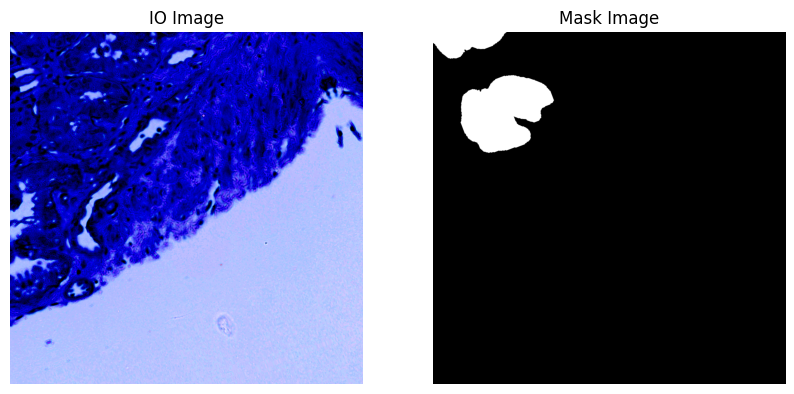

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Iterate through the batch of images and masks
for i in range(images.shape[0]):
    io_image = images[i].permute(1, 2, 0).numpy()  # Shift the channel to the end
    mask_image = masks[i].squeeze().numpy()  # Remove the channel dimension for mask

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the images
    axes[0].imshow(io_image)
    axes[0].set_title('IO Image')
    axes[0].axis('off')

    axes[1].imshow(mask_image, cmap='gray')
    axes[1].set_title('Mask Image')
    axes[1].axis('off')

    plt.show()



In [21]:
#!pip install segmentation-models-pytorch

In [22]:
#!pip install albumentations

In [18]:
import segmentation_models_pytorch as smp
import torch
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim



# note that this is one of the smallest models that i could find in TIMM - its unclear if we should go smaller/larger. left for future work
# however - i would suggest that we already make this a system setting parameter, so that folks can swap it out quickly without having to understand the consequence here
# this should be sufficiently decoupled, as the results themselves aren't really "connected" to the model, 
# i.e., if they change the model the weights will simply fail to load(need to have an error catch for that), and it'd begin retraining from scratch
# thus creating new appropriate weights. might be appropriate to consider using something like a pathology foundation model, even though they're likely too
# large for this sort of thing

# another idea here that we should make a ticket for is to conver this to more of a hoverfast type of approach, so that objects are successfully
# split. this seems important overall since many objects may be near each other, and in *this* version of QA, we have the ifnormation about the indivdiual
# polyongs which we didn't previously have in the last version since there was no way to collect individual polygon IDs via the UI, or store them in the backend
# this would give a very nice improvement, and i also don't think changes anything about the rest of the code- it would be a replacement within on the DL parts and
# abstracted away from the rest of the backend. i'd make a ticket for this and when things are working and solid, we can perhaps ping petros/julien to have them
# integrate it themselves directly.


# note we previously pretained the model in an autoencoding fashion - with these newer libraries, it seems more straight forward to do so:
# import segmentation_models_pytorch as smp
# import torch.nn as nn

# class AutoEncoderUNet(smp.Unet):
#     def forward(self, x):
#         # Encoder
#         features = self.encoder(x)
        
#         # Decoder (no skip connections)
#         x = features[-1]  # Use the deepest feature map
#         for stage in self.decoder.blocks:
#             x = stage(x)  # Pass through decoder blocks
        
#         # Segmentation head
#         x = self.segmentation_head(x)
#         return x

# # Create the model
# autoencoder_model = AutoEncoderUNet(
#     encoder_name="timm-mobilenetv3_small_100", 
#     encoder_weights="imagenet", 
#     in_channels=3, 
#     classes=3  # Classes set to 3 for RGB reconstruction
# )

# and change the loss function to MSE and send it the original image as the target. then we would load the weights:
# Load the trained autoencoder encoder weights into a standard UNet
# supervised_model = smp.Unet(
#     encoder_name="timm-mobilenetv3_small_100", 
#     encoder_weights=None,  # We'll load our weights
#     in_channels=3, 
#     classes=1
# )

# # Transfer weights from the autoencoder
# supervised_model.encoder.load_state_dict(autoencoder_model.encoder.state_dict())

# # Fine-tune the supervised model with a segmentation loss
# criterion = nn.BCEWithLogitsLoss()  # Example for binary segmentation


# first things first, get something thats working. 

# -- need to review the docs to figure out best parameters anyway, looks like some can be used to reduce size and memory footprint: https://smp.readthedocs.io/en/latest/models.html
model = smp.Unet(encoder_name="timm-mobilenetv3_small_100", encoder_weights="imagenet", in_channels=3, classes=1)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks,weights in tqdm(dataloader):
        print("done loading batch")
        images = images.to(device)
        masks = masks.to(device)
        weights = weights.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        print("doing forward pass")
        outputs = model(images)

        loss = criterion(outputs, masks.float()) 
        loss = (loss * (edge_weight ** weights).type_as(loss)).mean()

        # Mask for positives and unlabeled
        positive_mask = (masks == 1).float()
        unlabeled_mask = (masks == 0).float()

        # Weighted loss   -- these should be pulled up into project settings
        positive_loss = 1.0  * (loss * positive_mask).mean()
        unlabeled_loss = .1* (loss * unlabeled_mask).mean()




        loss_total  =  positive_loss + unlabeled_loss

        
        print("losses:\t",loss_total,positive_mask.sum(),positive_loss,unlabeled_loss)
        # Backward pass and optimize
        loss_total.backward()
        optimizer.step()

        running_loss += loss_total.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}")

print("Training complete")

cpu


0it [00:00, ?it/s]

cache hit
done loading batch
doing forward pass
losses:	 tensor(0.2161, grad_fn=<AddBackward0>) tensor(166123.) tensor(0.0631, grad_fn=<MulBackward0>) tensor(0.1530, grad_fn=<MulBackward0>)


1it [00:18, 18.41s/it]

done loading batch
doing forward pass
losses:	 tensor(0.2253, grad_fn=<AddBackward0>) tensor(221011.) tensor(0.0805, grad_fn=<MulBackward0>) tensor(0.1448, grad_fn=<MulBackward0>)


2it [00:25, 11.48s/it]

done loading batch
doing forward pass
losses:	 tensor(0.5818, grad_fn=<AddBackward0>) tensor(1395759.) tensor(0.4847, grad_fn=<MulBackward0>) tensor(0.0972, grad_fn=<MulBackward0>)


3it [00:35, 10.98s/it]

done loading batch
doing forward pass
losses:	 tensor(0.2945, grad_fn=<AddBackward0>) tensor(599713.) tensor(0.1841, grad_fn=<MulBackward0>) tensor(0.1104, grad_fn=<MulBackward0>)


4it [00:41,  9.21s/it]

done loading batch
doing forward pass
losses:	 tensor(0.2144, grad_fn=<AddBackward0>) tensor(366114.) tensor(0.1048, grad_fn=<MulBackward0>) tensor(0.1096, grad_fn=<MulBackward0>)


5it [00:51,  9.41s/it]

done loading batch
doing forward pass
losses:	 tensor(0.4377, grad_fn=<AddBackward0>) tensor(1078687.) tensor(0.3396, grad_fn=<MulBackward0>) tensor(0.0981, grad_fn=<MulBackward0>)


6it [00:59,  8.93s/it]

done loading batch
doing forward pass
losses:	 tensor(0.2022, grad_fn=<AddBackward0>) tensor(387368.) tensor(0.1020, grad_fn=<MulBackward0>) tensor(0.1002, grad_fn=<MulBackward0>)


7it [01:07,  8.49s/it]

done loading batch
doing forward pass
losses:	 tensor(0.1252, grad_fn=<AddBackward0>) tensor(88362.) tensor(0.0222, grad_fn=<MulBackward0>) tensor(0.1030, grad_fn=<MulBackward0>)


8it [01:17,  8.91s/it]

done loading batch
doing forward pass
losses:	 tensor(0.5682, grad_fn=<AddBackward0>) tensor(1703849.) tensor(0.4958, grad_fn=<MulBackward0>) tensor(0.0725, grad_fn=<MulBackward0>)


9it [01:23,  8.25s/it]

done loading batch
doing forward pass
losses:	 tensor(0.6567, grad_fn=<AddBackward0>) tensor(1570859.) tensor(0.5627, grad_fn=<MulBackward0>) tensor(0.0940, grad_fn=<MulBackward0>)


10it [01:30,  7.89s/it]

done loading batch
doing forward pass
losses:	 tensor(0.4231, grad_fn=<AddBackward0>) tensor(1336089.) tensor(0.3486, grad_fn=<MulBackward0>) tensor(0.0746, grad_fn=<MulBackward0>)


11it [01:38,  7.77s/it]

done loading batch
doing forward pass
losses:	 tensor(0.1503, grad_fn=<AddBackward0>) tensor(296070.) tensor(0.0649, grad_fn=<MulBackward0>) tensor(0.0854, grad_fn=<MulBackward0>)


12it [01:49,  8.70s/it]

done loading batch
doing forward pass
losses:	 tensor(0.8123, grad_fn=<AddBackward0>) tensor(2039768.) tensor(0.7347, grad_fn=<MulBackward0>) tensor(0.0776, grad_fn=<MulBackward0>)


13it [01:56,  8.37s/it]

done loading batch
doing forward pass
losses:	 tensor(0.7399, grad_fn=<AddBackward0>) tensor(1970476.) tensor(0.6648, grad_fn=<MulBackward0>) tensor(0.0750, grad_fn=<MulBackward0>)


14it [02:04,  8.91s/it]

done loading batch
doing forward pass


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Iterate through the batch of images and masks
for i in range(images.shape[0]):
    io_image = images[i].permute(1, 2, 0).numpy()  # Shift the channel to the end
    mask_image = masks[i].squeeze().numpy()  # Remove the channel dimension for mask

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the images
    axes[0].imshow(io_image)
    axes[0].set_title('IO Image')
    axes[0].axis('off')

    axes[1].imshow(mask_image, cmap='gray')
    axes[1].set_title('Mask Image')
    axes[1].axis('off')

    plt.show()



In [ ]:
dataset.cache.keys()

In [ ]:
image_id = 1
tile_id = 323
infertile = [t for t in tiles if t.image_id ==image_id and tile_id == t.id][0]
print(infertile)

In [ ]:
cache_key = f"{image_id}_{tile_id}"

if cache_key in dataset.cache:
    print("cache hit")
    io_image, mask_image,weight = dataset.cache[cache_key]
else:
    tpoly = shapely.wkb.loads(infertile.geom.data)

    # Get the bounds of the polygon
    minx, miny, maxx, maxy = tpoly.bounds

    # Compute the width and height
    width = int(maxx - minx)
    height = int(maxy - miny)

    #--- image work
    image = session.query(Image).filter_by(id=image_id).first()

    image_path = image.path
    slide = openslide.OpenSlide("../" + image_path)

    # Extract the region defined by the tile
    region = slide.read_region((int(minx), int(miny)), 0, (width, height))
    io_image = np.array(region.convert("RGB"))

print(io_image.shape)
plt.imshow(io_image)

In [28]:
io_orig = io_image.copy()

In [ ]:
io_image= io_orig.copy()
# Normalize the io_image
model.eval()
with torch.no_grad():
    io_image = io_image / 255.0  # Normalize to range [0, 1]
    io_image = (io_image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])  # Apply mean and std normalization
    io_image = np.pad(io_image, ((32, 32), (32, 32), (0, 0)), mode='reflect')

    io_image = torch.tensor(io_image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)  # Convert to tensor and move to device
    
    print(io_image.shape)
    # Pass through the model
    outputs = model(io_image)
    
    # Remove the padding
    outputs = outputs[:, :, 32:-32, 32:-32]
    print(outputs.shape)

In [30]:
outputs = outputs.squeeze().detach().cpu().numpy()

In [ ]:
plt.imshow(outputs>0)

In [ ]:
# import cv2

# # Normalize outputs to range [0, 255]
# outputs_normalized = (outputs - outputs.min()) / (outputs.max() - outputs.min())
# outputs_uint8 = (outputs_normalized * 255).astype(np.uint8)
# # Compute Otsu's threshold value
# otsu_threshold_value, _ = cv2.threshold(outputs_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# positive_mask = outputs_uint8 > otsu_threshold_value
# plt.imshow(positive_mask, cmap='gray')
# plt.show()


positive_mask = outputs> 0
plt.imshow(positive_mask, cmap='gray')
plt.show()


In [ ]:

# Merge groups of pixels which are at most 2 away
kernel = np.ones((2, 2), np.uint8)
positive_mask = cv2.dilate(positive_mask.astype(np.uint8), kernel, iterations=2)>0
plt.imshow(positive_mask>0)
plt.show()


In [ ]:

# Find contours in the positive mask
contours, _ = cv2.findContours(positive_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
len(contours)


In [ ]:

from shapely.geometry import Polygon, mapping

# Convert contours to shapely polygons
polygons = [Polygon(contour.squeeze()) for contour in contours if len(contour) > 2]

# Filter out small polygons
polygons = [polygon for polygon in polygons if polygon.area >= 100]


# Convert shapely polygons to GeoJSON
geojson = [mapping(polygon) for polygon in polygons]

# Print the GeoJSON
for feature in geojson:
    print(feature)
print(len(polygons))



In [162]:
# from matplotlib.patches import Polygon as MplPolygon

# import matplotlib.pyplot as plt

# #
# # Calculate the number of rows and columns
# num_polygons = len(polygons)
# num_columns = 5
# num_rows = (num_polygons + num_columns - 1) // num_columns

# # Create a figure for the contact sheet
# fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 3, num_rows * 3))

# # Flatten the axes array for easy iteration
# axes = axes.flatten()

# # Plot each polygon in the contact sheet
# for i, polygon in enumerate(polygons):
#     ax = axes[i]
#     ax.set_xlim(0, tile_width)
#     ax.set_ylim(0, tile_height)
#     ax.set_aspect('equal')
#     ax.axis('off')

#     # Adjust the coordinates of the polygon to match the image coordinates
#     coords = [(x - minx, tile_height - (y - miny)) for x, y in polygon.exterior.coords]

#     # Create a matplotlib polygon patch
#     poly_patch = MplPolygon(coords, closed=True, edgecolor='r', facecolor='blue', alpha=0.5)
#     ax.add_patch(poly_patch)

#     # Add a bounding box around the subplot
#     rect = plt.Rectangle((0, 0), tile_width, tile_height, linewidth=1, edgecolor='black', facecolor='none')
#     ax.add_patch(rect)

# # Hide any remaining empty subplots
# for j in range(i + 1, len(axes)):
#     axes[j].axis('off')

# plt.tight_layout()
# plt.show()

In [ ]:
plt.hist(outputs.flatten(), bins=512)
plt.title('Histogram of Output Distortion')
plt.xlabel('Output Values')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from matplotlib.patches import Polygon as MplPolygon
import random

num_polygons = len(polygons)

import matplotlib.pyplot as plt
# Generate a list of random colors for the polygons
colors = ['#%06X' % random.randint(0, 0xFFFFFF) for _ in range(num_polygons)]

# Create a single panel figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, tile_width)
ax.set_ylim(0, tile_height)
ax.set_aspect('equal')
ax.axis('off')

# Plot each polygon with a different color
for i, polygon in enumerate(polygons):
    coords = [(x - minx, tile_height - (y - miny)) for x, y in polygon.exterior.coords]
    poly_patch = MplPolygon(coords, closed=True, edgecolor='r', facecolor=colors[i], alpha=0.5)
    ax.add_patch(poly_patch)

plt.show()

In [ ]:
from quickannotator.db import Annotation

gtpred = 'pred'  # or 'pred' based on your requirement
table_name = build_annotation_table_name(image_id, class_id, gtpred == 'gt')
print(table_name)
# Define the table dynamically
table = Table(table_name, db.metadata, autoload_with=engine)

# Iterate through the list of polygons
for polygon in polygons:
    # Translate the polygon by the tile's minx and miny
    translated_polygon = shapely.affinity.translate(polygon, xoff=minx, yoff=miny)
    
    # Calculate the area and centroid of the polygon
    area = translated_polygon.area
    centroid = translated_polygon.centroid
    
    
    # Create a new annotation dictionary
    new_annotation = {
        'image_id': image_id,
        'annotation_class_id': class_id,
        'polygon': translated_polygon.wkt,
        'area': area,
        'isgt': False,
        'centroid': centroid.wkt  # Use the centroid variable directly
    }
    
    # Insert the new annotation into the table
    insert_stmt = table.insert().values(new_annotation)
    session.execute(insert_stmt)

# Commit the session to save the annotations to the database
session.commit()





In [ ]:
session.rollback()